In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lal

## Source

In [2]:
ra = np.pi/2. # right ascension
dec = np.pi/4. # declination

## Antenna patterns


In [3]:
# get detector tensors
L1_tensor = 1. * lal.cached_detector_by_prefix['L1'].response +  0.* lal.cached_detector_by_prefix['H1'].response
H1_tensor = lal.cached_detector_by_prefix['H1'].response
V1_tensor = lal.cached_detector_by_prefix['V1'].response

In [4]:
def get_antenna_patterns(tensor, ra, dec, gmst):
    
    def antenna_patterns(psi):
        ap = lal.ComputeDetAMResponse(tensor, ra, dec, psi, gmst) 
        return ap
    
    return antenna_patterns
        

In [5]:
gmst =  3.6e7# Greenwich mean sidereal time (can just pick one for testing)
no_psi = True
if no_psi:
    psi_F =  0.# polarisation angle
    L1_F = lal.ComputeDetAMResponse(L1_tensor, ra, dec, psi_F, gmst)
    H1_F = lal.ComputeDetAMResponse(H1_tensor, ra, dec, psi_F, gmst)
    V1_F = lal.ComputeDetAMResponse(V1_tensor, ra, dec, psi_F, gmst)
else:
    L1_F = get_antenna_patterns(L1_tensor, ra, dec, gmst)
    H1_F = get_antenna_patterns(H1_tensor, ra, dec, gmst)
    V1_F = get_antenna_patterns(V1_tensor, ra, dec, gmst)

## Strain

In [6]:
from package.constants import Msol, G, c

In [7]:
def reduced_mass(m1, m2):
    """
    Calculate the reduced mass of the system (often mu)
    """
    return m1*m2 / (m1+m2)


def eta(m1, m2):
    """
    ratio of redueced mass and total mass
    """
    return reduced_mass(m1, m2) / (m1+m2)


def omega(m1, m2, t, t_c):
    """
    demensionsless time variable
    """
    e = eta(m1, m2)
    M = m1 + m2
    return (c**3. * e) / (5.* G * M) * (t_c - t)


def freq(m1, m2, t, t_c):
    """
    frequency as a function of time
    """
    M = m1 + m2
    return c**3. / (8. * np.pi * G * M) * (omega(m1, m2 ,t, t_c))**-(3./8.)


def h0(m1, m2, r, phi_zero, t, t_c):
    """
    
    """
    fp, fc =  [1,1]#antenna_patterns
    M = m1 + m2
    mu = reduced_mass(m1, m2)
    f = freq(m1, m2 ,t, t_c)
    h0p = - (2.* G) / (c**4. * r) *  mu * (np.pi * G* M * f)**(2./3.) * np.exp(1j*phi_zero)#np.cos(2.*np.pi*f*t - 2*phi_zero)
    h0c = - (2.* G) / (c**4. * r) *  mu * (np.pi * G* M * f)**(2./3.) * np.exp(1j*(phi_zero + np.pi/2.))#np.sin(2.*np.pi*f*   t - 2*phi_zero)
    
    return h0p, h0c

### Fixed params

In [8]:
m1 = 25.*Msol
m2 = 28.*Msol
t = np.arange(0,10, 1./4096).astype(np.float32)
Nsamples = np.int32(t.shape[0])
t_c = 10.
r = 1000.
phi_zero = 0.
# get strain in wave frame (includes antenna patterns)
h0p, h0c = h0(m1, m2, r, phi_zero, t, t_c)

In [9]:
def strain(psi, iota, h0p, h0c, antenna_patterns):
    # antenna patterns
    Fplus, Fcross = antenna_patterns
    hplus = 0.5 * (1. + np.cos(iota)**2. ) * np.cos(2.*psi)*h0p + np.cos(iota)*np.sin(2.*psi) *h0c
    hcross = np.cos(iota) * np.cos(2.*psi)*h0c - 0.5*(1+ np.cos(iota)**2.) * np.sin(2.*psi) *h0p
    s = Fplus*hplus + Fcross*hcross
    return s

## Inner products

In [10]:
def cal_inner(a, b):
    """
    Computes the noise weighted inner product in the frequency domain
    Follows Babak et al Eq. 2
    """
    T_obs = 10.
    fs = np.float64(4096.)
    psd = 0.5*np.ones(20481)
    N = T_obs * fs
    df = 1.0 / T_obs
    dt = 1.0 / fs

    af = np.fft.fft(a)*dt
    bf = np.fft.fft(b)*dt
    temp = 4.0*np.real(np.sum((np.conj(af)*bf)))*df # should have psd
    return temp

## Variables of interest

In [11]:
def hh(s):
    return cal_inner(s,s)

def hd(s,d):
    return cal_inner(s,d)

def dd(d):
    return cal_inner(d)

# Psi and iota

In [12]:
N = 50
psi = np.linspace(-np.pi/2., np.pi/2., N)
iota = np.linspace(0, np.pi, N)

# One detector

In [13]:
def h_simple_1det(a,b,c, psi, iota, r=1):
    alpha = 20.
    gamma = 10.
    A = 0.5 * (1./r**2) * (((0.5*(1+ np.cos(iota)**2.0))**2. * np.cos(2.*psi)**2) * alpha + \
                           (np.cos(iota)**2. * (np.sin(2.*psi)**2)) * gamma) 
    B = (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.cos(2.*psi) * b + (1./r) *(np.cos(iota)) * np.sin(2.*psi) * c
    C = (1./r) *(np.cos(iota)) * np.cos(2.*psi) * c - (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.sin(2.*psi) * b
    
    return A,B,C

In [14]:
psi_m, iota_m = np.meshgrid(psi, iota)
ABC_1det = h_simple_1det(10,10,10, psi_m, iota_m)

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


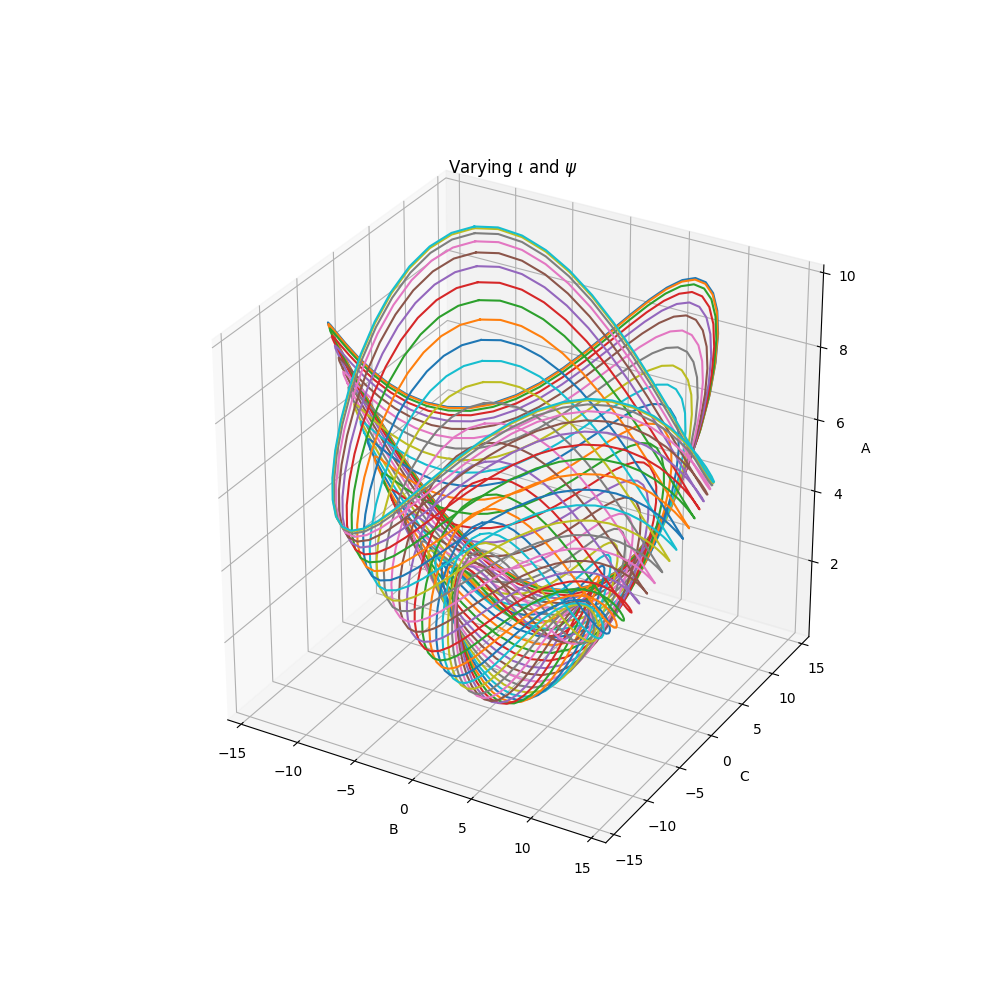

In [28]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(N):
    ax.plot(ABC_1det[1][i], ABC_1det[2][i], (ABC_1det[0][i]))
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

# Two detectors

## Most general case

In [18]:
antenna_patterns = [L1_F, H1_F]
noise = np.random.normal(0,1, (2,Nsamples)) + 1j*np.random.normal(0,1, (2,Nsamples))
D = noise + [strain(np.pi/3., np.pi/4., h0p, h0c,ap) for ap in antenna_patterns]

D[0].shape

plt.plot(D[0])

A = []
B = []

for p in psi:
    for i in iota:
        S = [strain(p, i, h0p, h0c, ap) for ap in antenna_patterns]
        a = np.sum([hh(s) for s in S])
        b = np.sum([hd(s, d) for s,d in zip(S, D)])
        A.append(a)
        B.append(b)
A = np.array(A)
B = np.array(B)

plt.plot(B.reshape(N,N), np.sqrt(A).reshape(N,N))
plt.show()

## Non-precessing

In [19]:
def h_simple_2det(a,b,c, psi, iota, det_ap, r=1):
    
    A = lambda psi, iota, fp, fc, k: 0.5 * (1./r**2) * (((0.5*(1+ np.cos(iota)**2.0))**2. * np.cos(2.*psi)**2) *fp**2. + (np.cos(iota)**2. * (np.sin(2.*psi)**2)) * fc**2.) * k
    B = lambda psi, iota, fp, k: (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.cos(2.*psi) * k *fp**2.
    C = lambda psi, iota, fc, k: (1./r) *(np.cos(iota)) * np.sin(2.*psi) * k *fc**2.
        
    A_val = np.sum([A(psi, iota, f[0], f[1], k) for f, k in zip(det_ap, a)], axis=0)
    B_val = np.sum([B(psi, iota, f[0], k) for f, k in zip(det_ap,b)], axis=0)
    C_val = np.sum([C(psi, iota, f[1], k) for f, k in zip(det_ap,c)], axis=0)
    
    return A_val,B_val,C_val

In [20]:
def h_multidet(psi=None, iota=None, r=1, a1=None, a2=None ,b_array=None,c_array=None, ap_array=None, return_all = True, **kwargs):
    """
    Params:
    
    psi - polarisation
    iota - inclination
    r - luminosity distance
    a1 = <h+|h+>
    a2 = <hx|hx>
    b = <h+|d>
    c = <hx|d>
    det_ap - set of antenna patterns (with psi = 0)
    """
    assert len(b_array) == len(ap_array)
    assert len(c_array) == len(ap_array)
    # a1 and a2 don't change
    def A(psi, iota, r, a1, a2, ap):
        val = (1./r**2) * (((0.5*(1+ np.cos(iota)**2.0))**2. * np.cos(2.*psi)**2) * a1 *ap[0]**2. + \
                (np.cos(iota)**2. * (np.sin(2.*psi)**2)) * a2 * ap[1]**2.) 
        return val
    
    def A_complete(psi, iota, r, a1, a2, ap):
        val = (1./r**2) * ((0.5*(1+ np.cos(iota)**2.0))**2. * a1 *ap[0]**2. * (1. - np.sin(4.*psi)) + \
                (np.cos(iota)**2. * a2 * ap[1]**2.) * (1. + np.sin(4.*psi))) 
        return val
    
    def A_partial(psi, iota, r, a1, a2, ap):
        val0 = (1./r**2) * (((0.5*(1+ np.cos(iota)**2.0))**2. * np.cos(2.*psi)**2) * a1 *ap[0]**2.)
        val1 = (1./r**2) * (np.cos(iota)**2. * (np.sin(2.*psi)**2)) * a2 * ap[1]**2. 
        return val0, val1
    
    def A_partial_complete(psi, iota, r, a1, a2, ap):
        val0 = (1./r**2) * (0.5*(1+ np.cos(iota)**2.0))**2. * a1 *ap[0]**2. * (1. - np.sin(4.*psi))
        val1 = (1./r**2) * (np.cos(iota)**2. * a2 * ap[1]**2.) * (1. + np.sin(4.*psi))
        return val0, val1
    
    def B(psi, iota, r, b, c, ap):
        val = (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.cos(2.*psi) * ap[0]*b + \
                (1./r) *(np.cos(iota)) * np.sin(2.*psi) * ap[1]*c
        return val
    
    def B_partial(psi, iota, r, b, c, ap):
        val0 = (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.cos(2.*psi) * ap[0]*b
        val1 = (1./r) *(np.cos(iota)) * np.sin(2.*psi) * ap[1]*c
        return val0, val1
    
    def C(psi, iota, r, b, c, ap):
        val = (1./r) *(np.cos(iota)) * np.cos(2.*psi) * c * ap[1] - \
                (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.sin(2.*psi) * ap[0]*b
        return val
    
    def C_partial(psi, iota, r, b, c, ap):
        val0 = (1./r) *(np.cos(iota)) * np.cos(2.*psi) * c * ap[1] 
        val1 =  - (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.sin(2.*psi) * ap[0]*b
        return val0, val1
    
    A_tot = np.sum([A_complete(psi, iota, r, a1, a2, ap) for ap in ap_array], axis = 0)
    B_tot = np.sum([B(psi, iota, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)
    C_tot = np.sum([C(psi, iota, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)

    A_partial_tot = np.sum([A_partial_complete(psi, iota, r, a1, a2, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)
    B_partial_tot = np.sum([B_partial(psi, iota, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)
    C_partial_tot = np.sum([C_partial(psi, iota, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)
    
    # returns
    if return_all:
        return A_tot, B_tot, C_tot, np.array([A_partial_tot, B_partial_tot, C_partial_tot])
    else:
        return A_tot, B_tot, C_tot

### Alt

In [21]:
def h_multidet_alt(alpha, beta, r, a1, a2 ,b_array,c_array, ap_array):
    """
    Params:
    
    psi - polarisation
    iota - inclination
    r - luminosity distance
    a1 = <h+|h+>
    a2 = <hx|hx>
    b = <h+|d>
    c = <hx|d>
    det_ap - set of antenna patterns (with psi = 0)
    """
    assert len(b_array) == len(ap_array)
    assert len(c_array) == len(ap_array)
    psi = 0.5*(alpha + beta)
    iota = 0.5*(alpha - beta)
    # a1 and a2 don't change
    def A(psi, iota, r, a1, a2, ap):
        val = 0.5 * (1./r**2) * (((0.5*(1+ np.cos(iota)**2.0))**2. * np.cos(2.*psi)**2) * a1 *ap[0]**2. + \
                (np.cos(iota)**2. * (np.sin(2.*psi)**2)) * a2 * ap[1]**2.) 
        return val
    
    def B(psi, iota, r, b, c, ap):
        val = (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.cos(2.*psi) * ap[0]*b + \
                (1./r) *(np.cos(iota)) * np.sin(2.*psi) * ap[1]*c
        return val
    
    def C(psi, iota, r, b, c, ap):
        val = (1./r) *(np.cos(iota)) * np.cos(2.*psi) * c * ap[1] - \
                (1./r) * (0.5*(1+ np.cos(iota)**2.0)) * np.sin(2.*psi) * ap[0]*b
        return val
    
    A_tot = np.sum([A(psi, iota, r, a1, a2, ap) for ap in ap_array], axis = 0)
    B_tot = np.sum([B(psi, iota, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)
    C_tot = np.sum([C(psi, iota, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)

    return A_tot, B_tot, C_tot

### PQT

In [22]:
def h_multidet_pqt(r, a1, a2 ,b_array,c_array, ap_array, p, q, t):
    """
    Params:
    
    psi - polarisation
    iota - inclination
    r - luminosity distance
    a1 = <h+|h+>
    a2 = <hx|hx>
    b = <h+|d>
    c = <hx|d>
    det_ap - set of antenna patterns (with psi = 0)
    """
    assert len(b_array) == len(ap_array)
    assert len(c_array) == len(ap_array)
    # a1 and a2 don't change
    def A(p,q,t, r, a1, a2, ap):
        val = 0.5 * (1./r**2) * ((p*q/t)**2. * a1 *ap[0]**2. + \
                t**2. * a2 * ap[1]**2.) 
        return val
    
    def B(p, q, t, r, b, c, ap):
        val = (1./r) * (p*q/t) * ap[0]*b + \
                (1./r) *t * ap[1]*c
        return val
    
    def C(p,q, r, b, c, ap):
        val = (1./r) *p * c * ap[1] - \
                (1./r) * q * ap[0]*b
        return val
    
    A_tot = np.sum([A(p,q, t, r, a1, a2, ap) for ap in ap_array], axis = 0)
    B_tot = np.sum([B(p, q, t, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)
    C_tot = np.sum([C(p,q, r, b, c, ap) for b,c,ap in zip(b_array, c_array, ap_array)], axis = 0)

    return np.exp(-0.5*A_tot) + np.i0(B_tot+C_tot)

### Integrals over $\iota$ and $\psi$

In [23]:
from functools import partial

In [33]:
def multidet_int(psi, iota):
    A, B, C = h_multidet(psi, iota, 1, 20, 20, b_array, c_array, ap_array, return_all = False)
    return np.exp(-0.5*A) + np.i0(B+C)

In [34]:
def multidet_int_alt(iota, psi):
    
    A, B, C = h_multidet(psi, iota, 1, 20, 20, b_array, c_array, ap_array, return_all = False)
    return np.exp(-0.5*A) + np.i0(B+C)

In [35]:
from scipy.integrate import dblquad, tplquad
import time

In [40]:
i0, i1 = 0., np.pi
p0, p1 = lambda i: -np.pi/2., lambda i: np.pi/2.
#z, _ = quad(l_r, r0, r1, args=(np.pi))
ts = time.time()
z, e = dblquad(multidet_int_alt, i0, i1, p0, p1)
tf = time.time()
#z, _ = tplquad(multidet_int, p0, p1, q0, q1, t0, t1)
print(f'Integral value: {z} +/- {e}')
print(f'Runtime: {tf-ts}s')

Integral value: 34.096057025014915 +/- 3.242754143162088e-08
Runtime: 2.090557813644409s


In [41]:
p0, p1 = -np.pi/2., np.pi/2.
i0, i1 = lambda p: 0., lambda p: np.pi
#z, _ = quad(l_r, r0, r1, args=(np.pi))
ts = time.time()
z, e = dblquad(multidet_int, p0, p1, i0, i1)
tf = time.time()
#z, _ = tplquad(multidet_int, p0, p1, q0, q1, t0, t1)
print(f'Integral value: {z} +/- {e}')
print(f'Runtime: {tf-ts}s')

Integral value: 34.09605702501491 +/- 1.0625099042892051e-07
Runtime: 1.8764879703521729s


### Plots

In [68]:
N = 50
psi0 = np.linspace(-np.pi/8.,7.*np.pi/8., N)
psi1 = np.linspace(7.*np.pi/8. ,11.*np.pi/8. , N)
iota = np.linspace(0,np.pi, N)

In [88]:
psi_m0, iota_m0 = np.meshgrid(psi0, iota)
psi_m1, iota_m1 = np.meshgrid(psi1, iota)
iota_n, psi_n = np.meshgrid(iota, psi)
b_array = [10, 10]
c_array = [20, 20]
ap_array = [L1_F, H1_F]
r_array = [1., 2.]
h_array0 = []
h_array1 = []

for r in r_array:
    h_array0.append(h_multidet(psi_m0, iota_m0, r = r, 
                    a1 = 10, a2 = 10, b_array = b_array, c_array = c_array, 
                    ap_array=ap_array))
    h_array1.append(h_multidet(psi_m1, iota_m1, r = r, 
                    a1 = 10, a2 = 10, b_array = b_array, c_array = c_array, 
                    ap_array=ap_array))
# for p in p_array:
#     for q in q_array:
#         for t in t_array:
#              h_array.append(h_multidet_pqt(p, q, t, r = r, 
#                             a1 = 10, a2 = 10, b_array = b_array, c_array = c_array, 
#                             ap_array=ap_array))
h_array0 = np.array(h_array0)
h_array1 = np.array(h_array1)

h_array[0,-1].shape

In [70]:
psi_m, iota_m = np.meshgrid(psi, iota)
iota_n, psi_n = np.meshgrid(iota, psi)
b_array = [10,10]
c_array = [10, 10]
ap_array = [H1_F, L1_F]
r_array = [1., 2.]#np.arange(1.,10.,0.5)
h_array = []
h_array_n = []
# p_array = np.linspace(0, 1., 50)
# q_array = np.linspace(-1, 1., 50)
# t_array = np.linspace(-1, 1., 50)
# r = 1.

for r in r_array:
    h_array.append(h_multidet(psi_m, iota_m, r = r, 
                    a1 = 10, a2 = 10, b_array = b_array, c_array = c_array, 
                    ap_array=ap_array))
    h_array_n.append(h_multidet(psi_n, iota_n, r = r, 
                a1 = 10, a2 = 10, b_array = b_array, c_array = c_array, 
                ap_array=ap_array))
h_array = np.array(h_array)
h_array_n = np.array(h_array_n)

In [71]:
def plot_shape(h_det, ax, sqrt=False, **kwargs):
    N = len(h_det[0])
    if sqrt:
        for i in range(N):
            ax.plot(h_det[1][i], h_det[2][i], np.sqrt(h_det[0][i]), **kwargs)
    else:
        for i in range(N):
            ax.plot(h_det[1][i], h_det[2][i], (h_det[0][i]), **kwargs)

h_array = (h_array.reshape(50,50,50,3))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for ii in range(len(p_array)):
    for jj in range(len(q_array)):
        plt.plot(h_array[ii, jj, :, 1], h_array[ii, jj, :, 2], (h_array[ii, jj, :, 0]))
#ax.plot_surface(xx, yy, z, alpha = 0.2)
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')

plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

### A vs (B+C)

<IPython.core.display.Javascript object>


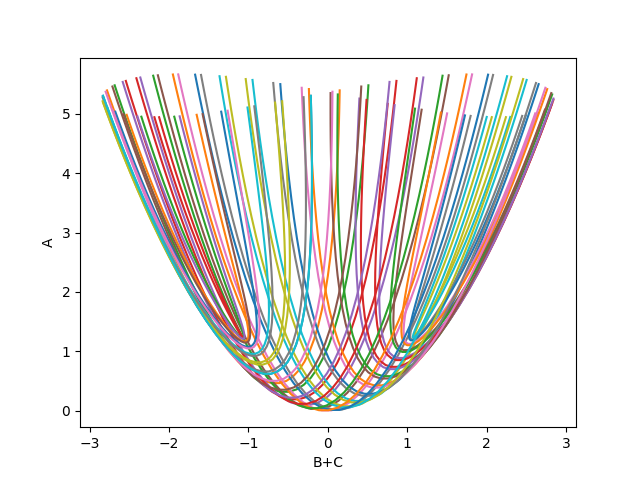

(50, 50) (50, 50)


In [72]:
plt.figure()
x = h_array[0,1]+h_array[0,2]
y = h_array[0,0]
x1 = h_array[1,1]+h_array[1,2]
y1 = h_array[1,0]
print(x.shape, y.shape)
plt.plot(x,y)
# plt.plot(x1,y1)
plt.ylabel('A')
plt.xlabel('B+C')
plt.show()

<IPython.core.display.Javascript object>


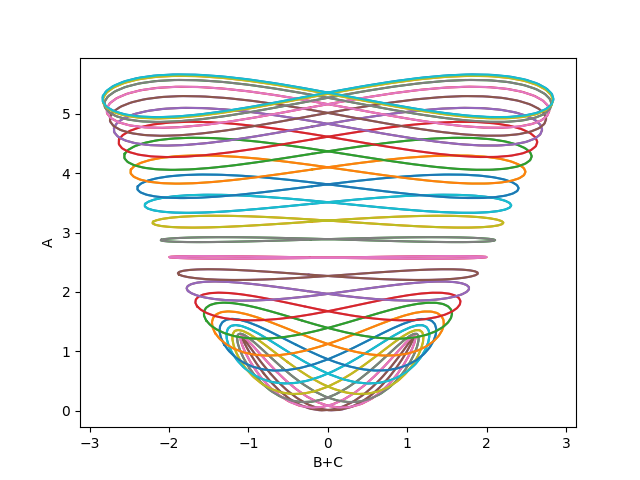

(50, 50) (50, 50)


In [73]:
plt.figure()
x = h_array_n[0,1]+h_array_n[0,2]
y = h_array_n[0,0]
x1 = h_array_n[1,1]+h_array_n[1,2]
y1 = h_array_n[1,0]
print(x.shape, y.shape)
plt.plot(x,y)
#plt.plot(x1,y1)
plt.ylabel('A')
plt.xlabel('B+C')
plt.show()

<IPython.core.display.Javascript object>


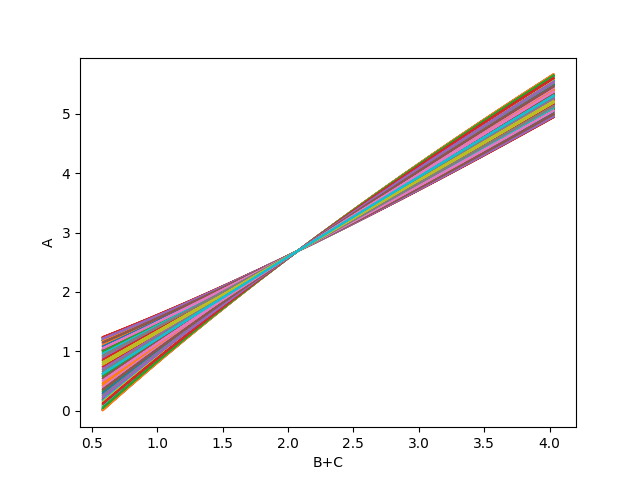

(50, 50) (50, 50)


In [74]:
plt.figure()
x = h_array[0,1]**2.+h_array[0,2]**2.
y = h_array[0,0]
x1 = h_array[1,1]+h_array[1,2]
y1 = h_array[1,0]
print(x.shape, y.shape)
plt.plot(x,y)
# plt.plot(x1,y1)
plt.ylabel('A')
plt.xlabel('B+C')
plt.show()

<IPython.core.display.Javascript object>


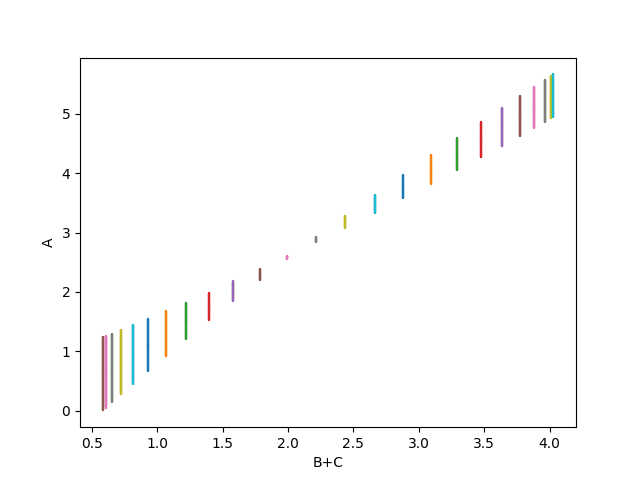

(50, 50) (50, 50)


In [75]:
plt.figure()
x = h_array_n[0,1]**2.+h_array_n[0,2]**2.
y = h_array_n[0,0]
x1 = h_array_n[1,1]+h_array_n[1,2]
y1 = h_array_n[1,0]
print(x.shape, y.shape)
plt.plot(x,y)
#plt.plot(x1,y1)
plt.ylabel('A')
plt.xlabel('B+C')
plt.show()

### Minima

In [76]:
def plot_minima(h_array, label):
    fig = plt.figure()
    con = plt.contourf(psi_m, iota_m, h_array, 50)
    idx = np.array([np.argsort(np.abs(h_array))[:,:2][0], np.argsort(np.abs(h_array), axis=0)[:,:2][0]])
    #plt.plot(psi_m[idx[0,1], idx[0,0]],iota_m[idx[0,1], idx[0,0]], 'r.', label = r'Minima in data')
    #plt.plot(psi_m[idx[1,1], idx[1,0]],iota_m[idx[1,1], idx[1,0]], 'r.')
    #plt.plot([-np.pi/4., np.pi/4.], [np.pi/2., np.pi/2.], 'm.', label = r'$\pm\pi/4$, $\pi/2$')
    cbar = plt.colorbar(con)
    cbar.set_label(label)
    plt.xlabel(r'$\psi$')
    plt.ylabel(r'$\iota$')
    #plt.legend()
    #fig.savefig('A_varation_2det.png', dpi = 400)
    plt.show()

<IPython.core.display.Javascript object>


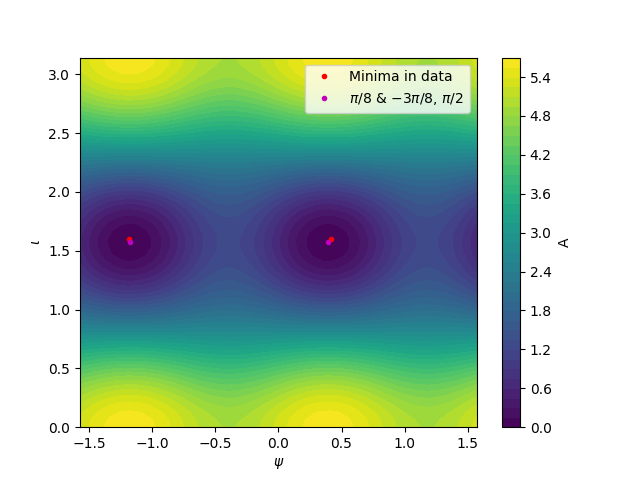

In [77]:
fig = plt.figure()
con = plt.contourf(psi_m, iota_m, h_array[0,0], 50)
idx = np.where((h_array[0,0])==h_array[0,0].min())
idx = np.array([np.argsort(h_array[0,0])[:,-2:][0], np.argsort(h_array[0,0], axis=0)[:,:2][0]]).T
plt.plot(psi_m[idx[0,1], idx[0,0]],iota_m[idx[0,1], idx[0,0]], 'r.', label = r'Minima in data')
plt.plot(psi_m[idx[1,1], idx[1,0]],iota_m[idx[1,1], idx[1,0]], 'r.')
plt.plot([-3.*np.pi/8., np.pi/8.], [np.pi/2., np.pi/2.], 'm.', label = r'$\pi/8$ & $-3\pi/8$, $\pi/2$')
cbar = plt.colorbar(con)
cbar.set_label('A')
plt.xlabel(r'$\psi$')
plt.ylabel(r'$\iota$')
plt.legend()
fig.savefig('A_varation_2det.png', dpi = 400)
plt.show()

<IPython.core.display.Javascript object>


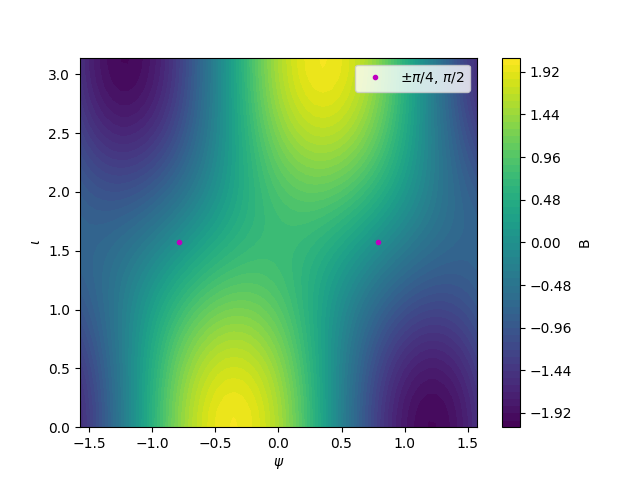

In [78]:
fig = plt.figure()
con = plt.contourf(psi_m, iota_m, h_array[0,1], 50)
plt.plot([-np.pi/4., np.pi/4.], [np.pi/2., np.pi/2.], 'm.', label = r'$\pm\pi/4$, $\pi/2$')
cbar = plt.colorbar(con)
cbar.set_label('B')
plt.xlabel(r'$\psi$')
plt.ylabel(r'$\iota$')
plt.legend()
fig.savefig('B_varation_2det.png', dpi = 400)
plt.show()

<IPython.core.display.Javascript object>


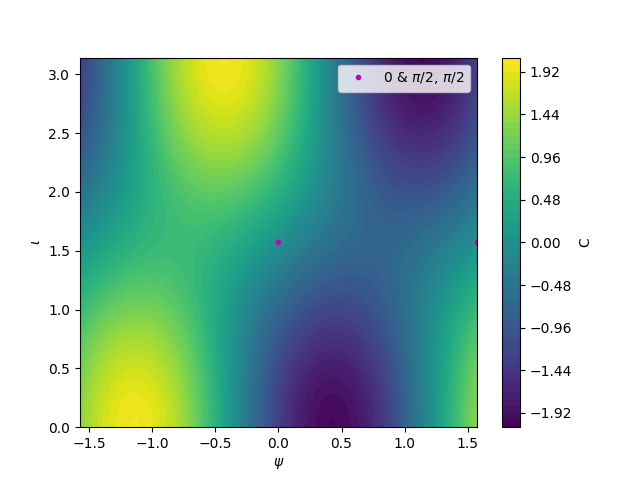

In [79]:
fig = plt.figure()
con = plt.contourf(psi_m, iota_m, h_array[0,2], 50)
plt.plot([0., np.pi/2.], [np.pi/2., np.pi/2.], 'm.', label = r'$0$ & $\pi/2$, $\pi/2$')
cbar = plt.colorbar(con)
cbar.set_label('C')
plt.xlabel(r'$\psi$')
plt.ylabel(r'$\iota$')
plt.legend()
fig.savefig('C_varation_2det.png', dpi = 400)
plt.show()

fig, axs = plt.subplots(3,1)
axs = axs.ravel()
axs[0].plot(psi, h_array[0,0,:,0])
axs[1].plot(iota, h_array[0,1,0,:].flatten())
#axs[2].plot(psi, h_array[0,2,:,0].flatten())
plt.show()

### Overall

<IPython.core.display.Javascript object>


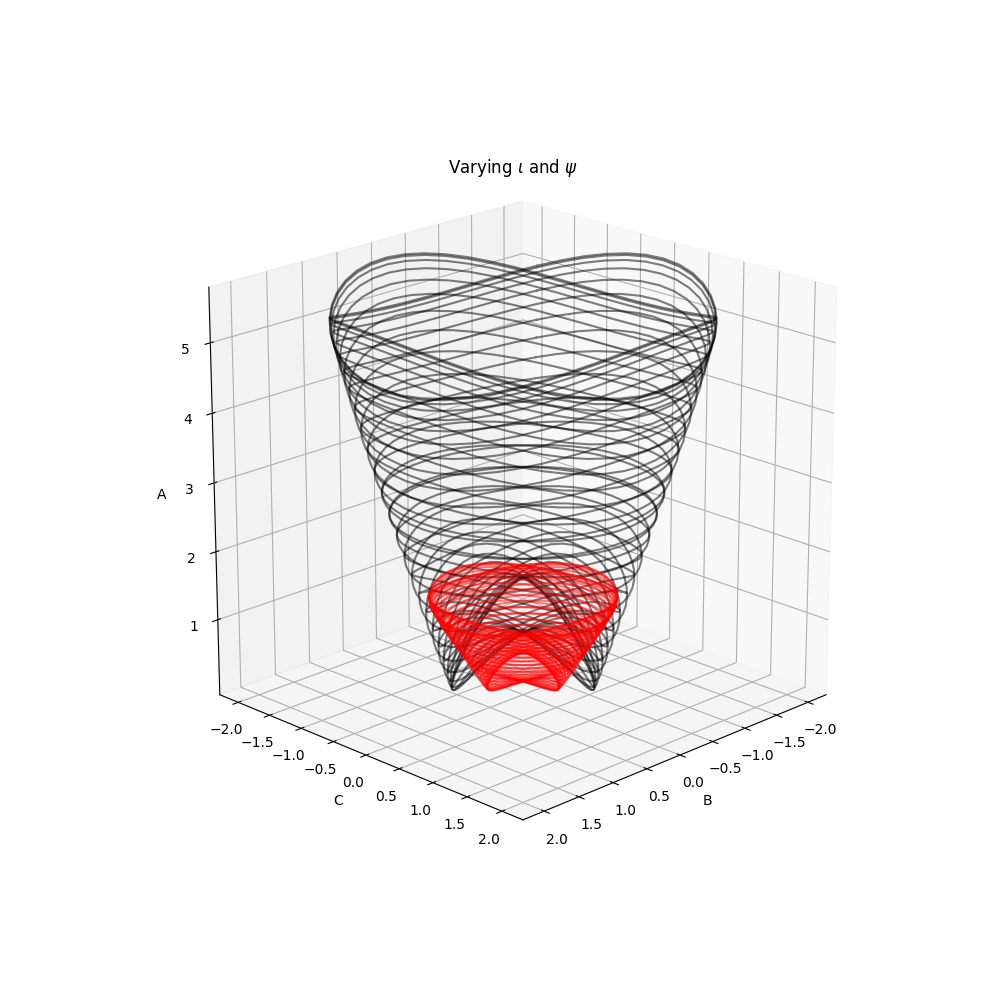

In [80]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

colours = ['k', 'r', 'g']
if len(colours) >= len(r_array):
    for i,c in enumerate(colours[:len(r_array)]):
        plot_shape(h_array[i], ax, sqrt = False, color = c, alpha = 0.5, linestyle = '-')
else:
    n = len(r_array)
    colours = plt.cm.rainbow(np.linspace(0,1,n))
    for i in range(n):
        plot_shape(h_array[i], ax, sqrt = False, color = colours[i], alpha = 0.5, linestyle = '-')

# plot_shape(h_array[3], ax, color = 'g', alpha = 0.5, linestyle = '-')


    
########
# surface
#########

# x = np.linspace(np.min(h_array[0][1][:][:]), np.max(h_array[0][1][:][:]), 10)
# y = np.linspace(np.min(h_array[0][2][:][:]), np.max(h_array[0][2][:][:]), 10)
# xx, yy = np.meshgrid(x, y)
# z = np.zeros([10,10])
# ax.plot_surface(xx, yy, z, alpha = 0.2)

#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()
#fig.savefig('psi_iota_r_2det.png')

<IPython.core.display.Javascript object>


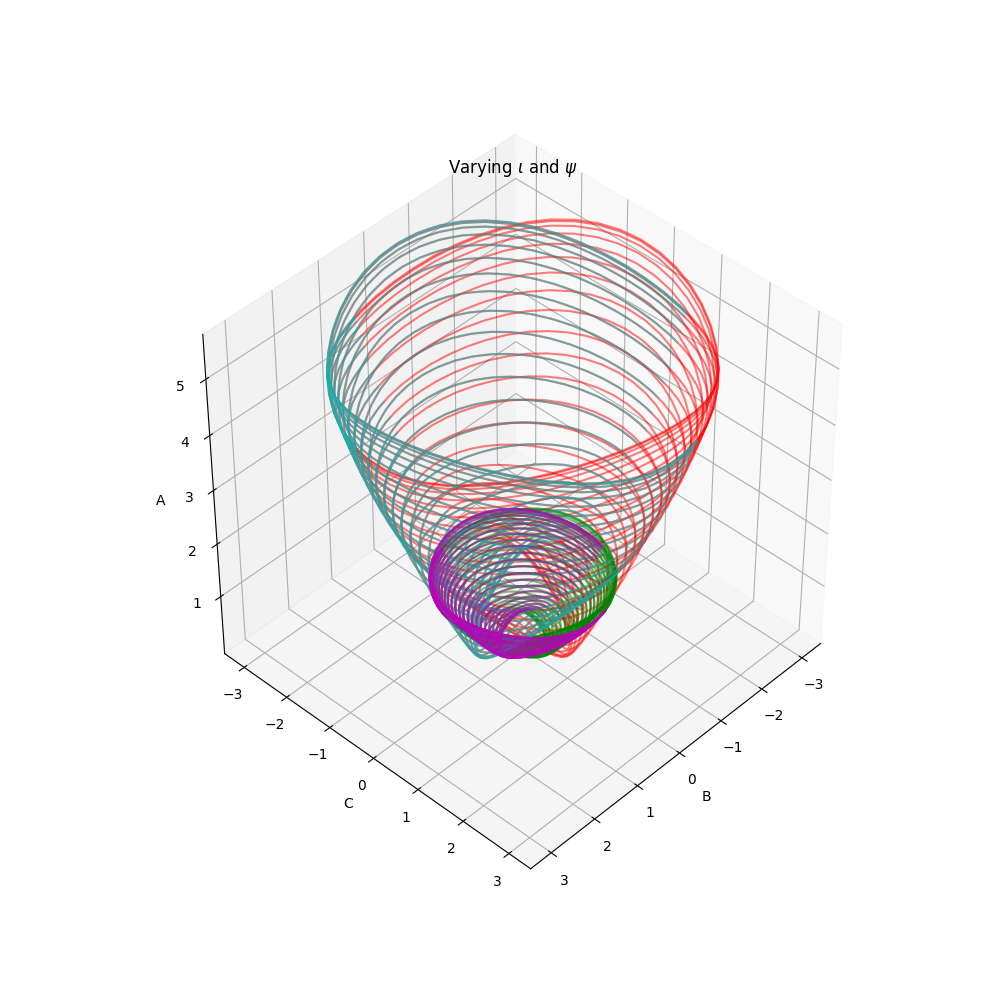

In [93]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

colours = ['r', 'g']
if len(colours) >= len(r_array):
    for i,c in enumerate(colours[:len(r_array)]):
        plot_shape(h_array0[i], ax, sqrt = False, color = c, alpha = 0.5, linestyle = '-')
else:
    n = len(r_array)
    colours = plt.cm.rainbow(np.linspace(0,1,n))
    for i in range(n):
        plot_shape(h_array0[i], ax, sqrt = False, color = colours[i], alpha = 0.5, linestyle = '-')

colours = ['c', 'm']
if len(colours) >= len(r_array):
    for i,c in enumerate(colours[:len(r_array)]):
        plot_shape(h_array1[i], ax, sqrt = False, color = c, alpha = 0.5, linestyle = '-')
else:
    n = len(r_array)
    colours = plt.cm.rainbow(np.linspace(0,1,n))
    for i in range(n):
        plot_shape(h_array1[i], ax, sqrt = False, color = colours[i], alpha = 0.5, linestyle = '-')

    
########
# surface
#########

# x = np.linspace(np.min(h_array[0][1][:][:]), np.max(h_array[0][1][:][:]), 10)
# y = np.linspace(np.min(h_array[0][2][:][:]), np.max(h_array[0][2][:][:]), 10)
# xx, yy = np.meshgrid(x, y)
# z = np.zeros([10,10])
# ax.plot_surface(xx, yy, z, alpha = 0.2)

#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

<IPython.core.display.Javascript object>


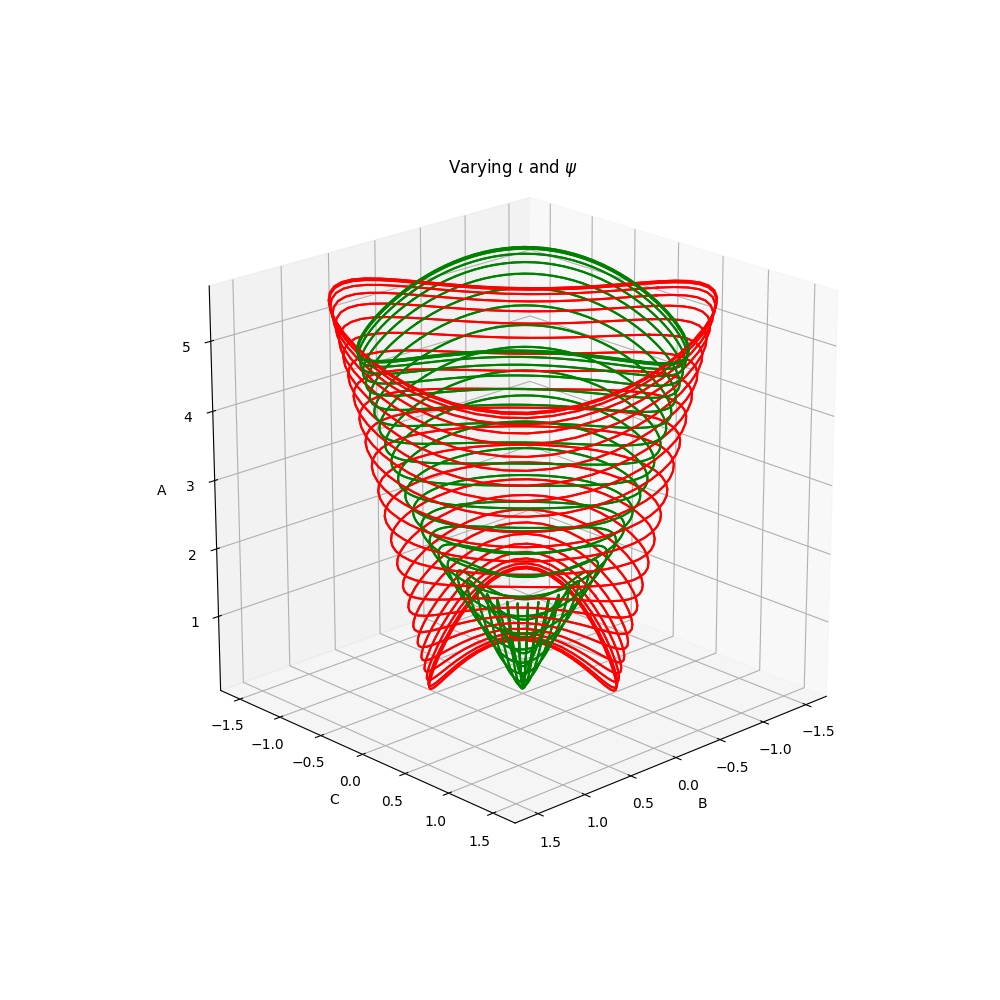

(4,)


In [81]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

###############
# Decomposition
###############

h_det = h_array[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i], (h_det[3][0,0][i]+h_det[3][0,1][i]), color = 'r')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i],  (h_det[3][0,0][i]+h_det[3][0,1][i]), color = 'g')

    
#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

### $\sqrt{A}$

<IPython.core.display.Javascript object>


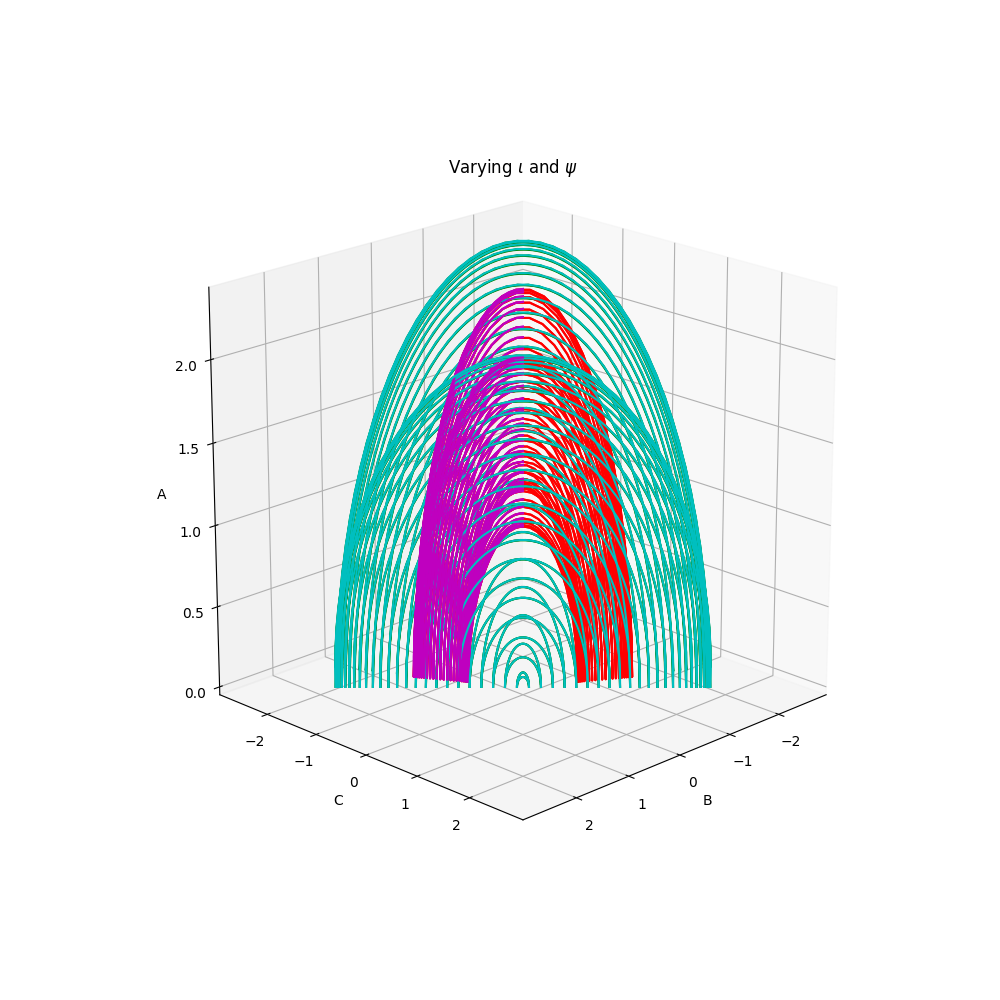

(4,)
(4,)


In [82]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

###############
# Decomposition
###############

h_det = h_array0[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i], np.sqrt(h_det[3][0,0][i]), color = 'r')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i],  np.sqrt(h_det[3][0,1][i]), color = 'g')

h_det = h_array1[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i],  np.sqrt(h_det[3][0,0][i]), color = 'm')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i],  np.sqrt(h_det[3][0,1][i]), color = 'c')  
    
#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

### $A$

<IPython.core.display.Javascript object>


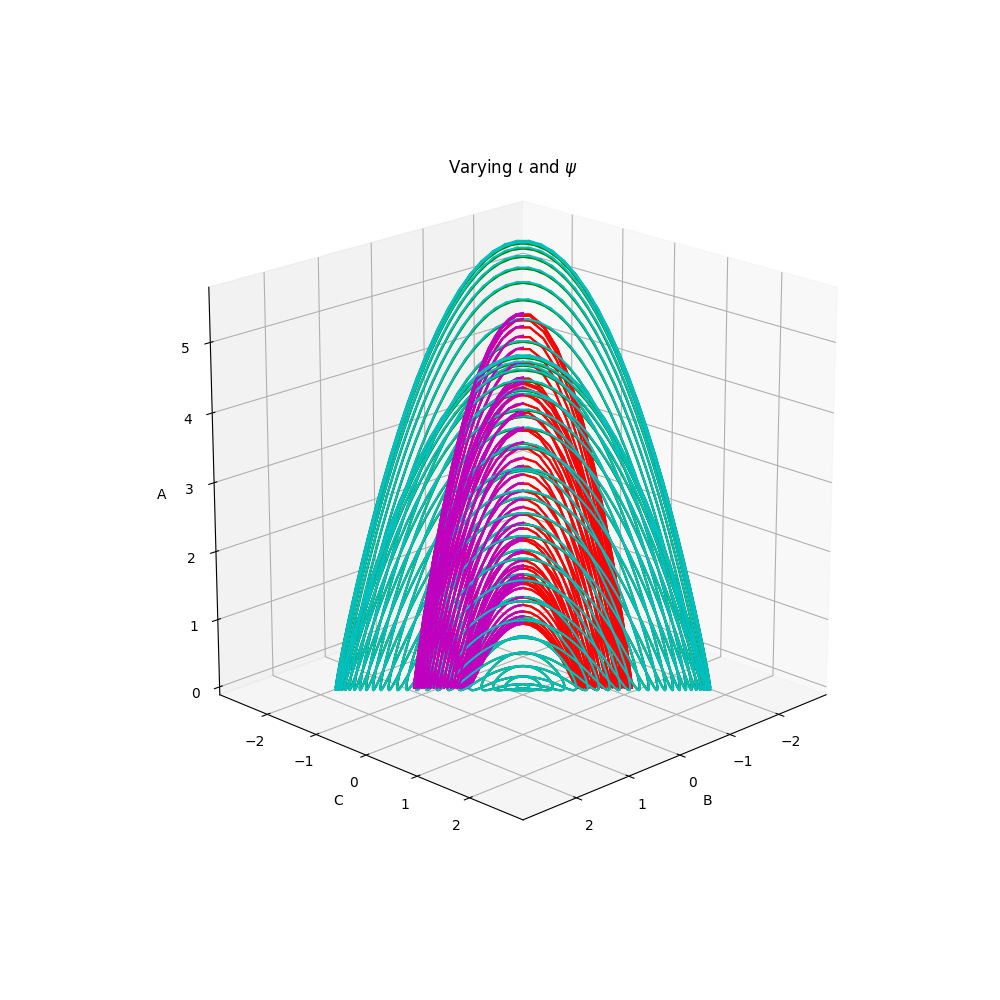

(4,)
(4,)


In [83]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

###############
# Decomposition
###############

h_det = h_array0[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i],  (h_det[3][0,0][i]), color = 'r')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i],  (h_det[3][0,1][i]), color = 'g')

h_det = h_array1[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i],  (h_det[3][0,0][i]), color = 'm')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i],  (h_det[3][0,1][i]), color = 'c')  
    
#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

### A

<IPython.core.display.Javascript object>


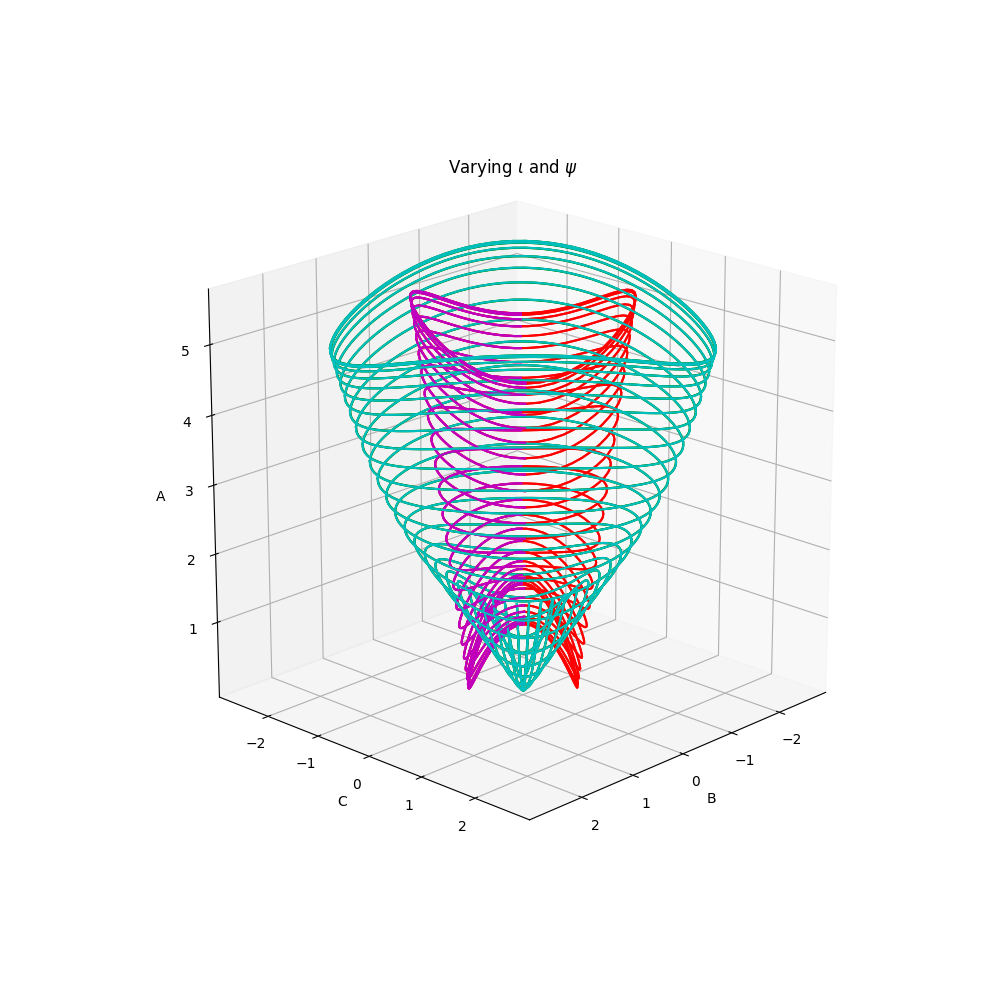

(4,)
(4,)


In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

###############
# Decomposition
###############

h_det = h_array0[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    # hp
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i], h_det[3][0,0][i]+h_det[3][0,1][i], color = 'r')
    # hc
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i], h_det[3][0,1][i]+h_det[3][0,0][i], color = 'g')

h_det = h_array1[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    # hp
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i], h_det[3][0,0][i]+h_det[3][0,1][i], color = 'm')
    #hc
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i], h_det[3][0,1][i]+h_det[3][0,0][i], color = 'c')  
    
#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()

### $\sqrt{A}$

<IPython.core.display.Javascript object>


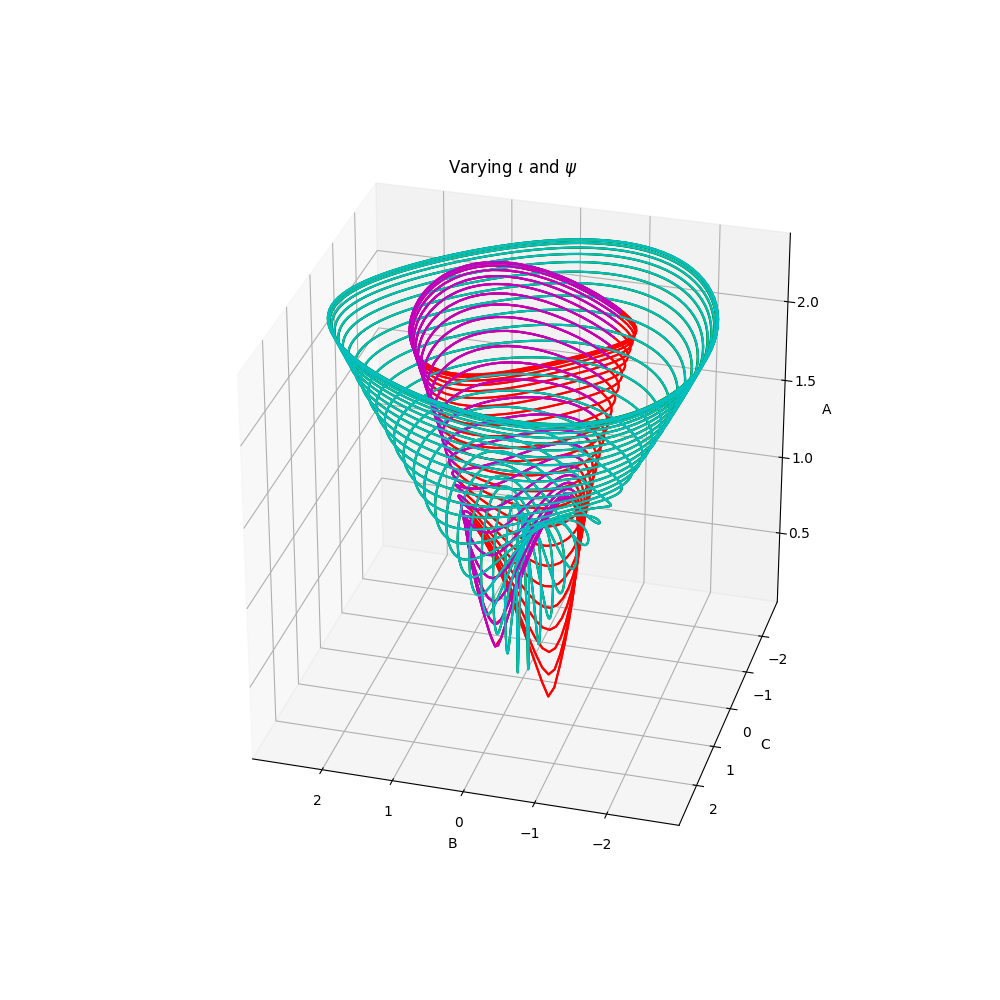

(4,)
(4,)


In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

###############
# Decomposition
###############

h_det = h_array0[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i], np.sqrt(h_det[3][0,0][i]+h_det[3][0,1][i]), color = 'r')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i], np.sqrt(h_det[3][0,1][i]+h_det[3][0,0][i]), color = 'g')

h_det = h_array1[0]
N = len(h_det[0])
print(h_det.shape)
for i in range(N):
    ax.plot(h_det[3][1,0][i], h_det[3][2,1][i], np.sqrt(h_det[3][0,0][i]+h_det[3][0,1][i]), color = 'm')
    ax.plot(h_det[3][1,1][i], h_det[3][2,0][i], np.sqrt(h_det[3][0,1][i]+h_det[3][0,0][i]), color = 'c')  
    
#########
# labels
########
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A')
ax.view_init(20, azim=45)
plt.title(r'Varying $\iota$ and $\psi$')
plt.show()